In [1]:
# Packages
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Atmosphere parameters
Cn2_h0 = 1e-17       # baseline Cn^2 [m^(-2/3)] (weak: 1e-17, strong: 1e-12)
V = 23           # visibility [km]
vG = 5.0            # ground wind [m/s] (weak: 5, strong: 10)
vT = 20.0            # tropopause wind [m/s] (weak: 20, strong: 30)
HT = 10000.0         # tropopause height [m]
LT = 1000.0          # tropopause thickness [m]
M = 1                # turbulence scaling
RE = 6370e3          # Earth radius [m]
L0 = 50              # turbulence outer scale (100-50) [m] (size of largest eddies)
phi = np.deg2rad(90)    # angle between the wind direction and the zenith

# Operational parameters
lam = 1550e-9       # wavelength [m]
w0 = 0.1            # initial beam waist [m]
h0 = 10             # ground station height [m]


# Satellite parameters
h = 300e3            # satellite altitude [m]
zeta = np.deg2rad(30)  # zenith angle

# Receiver parameters 
hg = 100             # ground elevation above sea level [m]
k0 = 2*np.pi / L0   # outer scale wavenumber

# Candidate operational parameters 
lambdas = [810e-9, 1064e-9, 1550e-9]    # wavelengths [nm] (lambda)
beam_waists = [0.005, 0.05, 0.1]        # initial beam waists [m] (w0)
station_heights = [0, 10, 20]           # ground station heights [m] (h)

# Detector/QKD parameters
eta_QE = 0.7        # quantum efficiency
Delta_lambda_nm = 1.0   # wavelength filter[nm]
Delta_lambda = Delta_lambda_nm * 1e-9   # [m]
dt = 1e-9               # integration time [s]
H_sky = 1e-6            # spectral sky radiance [W/m^2/sr/nm] for 1550 nm at night

# Physical constants
hP = 6.626e-34   # Planck's constant [Js]
c = 3e8           # speed of light [m/s]
Eph = hP*c/lam    # photon energy [J]
k = 2*np.pi/lam   # wavenumber

# aperture radius candidates
aR_values = np.linspace(0.05, 0.5, 100)

In [2]:
# Kim model 
def p_func(V):
    """Gives the exponent p in the Kim model based on visibility V [km]"""
    if V > 50: return 1.6
    elif 6 <= V <= 50: return 1.3
    elif 1 <= V < 6: return 0.16 * V + 0.34
    elif 0.5 <= V < 1: return V - 0.5
    elif V < 0.5: return 0
    else: return 1.3

# Wind velocity profile
def v_profile(hh, zeta):
    bracket = np.sqrt(np.sin(phi)**2 + (np.cos(phi)**2) * (np.cos(zeta)**2))
    return vG + vT * np.exp(-(((hh + hg) * np.cos(zeta) - HT) / LT)**2) * bracket

# Refractive index structure parameter model (Stotts et al. 2023)
def Cn2_profile(hh, h0):
    vhh = v_profile(hh, zeta)
    term1 = 1.04e-3 * (9.0 / vhh)**2 * ((hh + hg)/1e5)**10 * np.exp(-(hh+hg)/1200.0)
    term2 = 2.7e-16 * np.exp(-(hh+hg)/1700.0)
    term3 = Cn2_h0 * (h0 / (hh + 1e-9))**(4/3)
    return M * (term1 + term2) + term3

# Efficiency component functions
def eta_weather(gamma, L_atm): 
    """Gives the transmittance of the atmosphere based on the attenuation coefficient gamma and the slant path"""
    return np.exp(-gamma * L_atm)

def eta_lt(aR, wLT, b): 
    """Gives the efficiency due to light truncation at the receiver aperture"""    
    return np.exp(-2 * b**2 / (wLT**2)) - np.exp(-2 * aR**2 / (wLT**2))

# Coupling efficiency according to the model in Jovanovic et al 2017
def strehl_ratio(DR, r0):
    return (1 + (DR/r0)**(5/3))**(-6/5)

def eta_coupling_strehl(aR, r0):
    return (74*strehl_ratio(2*aR, r0)+1.84)/100

# Total transmittance (efficiency)
def eta_tot(gamma, L_atm, aR, wLT, b, eta_QE, r0):
    return (eta_weather(gamma,L_atm) *
            eta_lt(aR,wLT, b) *
            eta_coupling_strehl(aR,r0) *
            eta_QE)

# Main calculation function
def evaluate(lam, aR, b, DR,A_tel) :
    # Beam wander variance (σ²_turb ~ β² scaling)
    beta2 = 2.91 * (1/np.cos(zeta)) * integral_r0 * DR**(-1/3)

    # Total efficiency
    St = eta_coupling_strehl(aR, r0)
    eta_tot_val = eta_tot(gamma, L_atm, aR, w_LT, b, eta_QE, r0)
    eta_lt_val = eta_lt(aR, w_LT, b)

    # Background
    Omega_fov = np.pi * (1.22 * lam / (2*aR) * (1 + ((2*aR)/r0)**(5/3))**(3/5))**2
    p_bg = H_sky * Delta_lambda_nm * Omega_fov * A_tel * dt / Eph

    return {"aR_m" : aR, "St" : St,"gamma": gamma, 
            "w_L": w_L, "w_LT": w_LT, "r0": r0, 
            "eta_tot": eta_tot_val, "eta_lt": eta_lt_val, 
            "beta2": beta2, "Omega_fov": Omega_fov, "p_bg": p_bg
    }

In [3]:
# Atmospheric attenuation
p = p_func(V)
gamma = ((3.91 / V) * (lam * 1e9 / 550) ** (-p)) / 1000.0  # [1/m]

# Slant lengths
L = np.sqrt((RE + h)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)
L_atm = np.sqrt((RE + HT)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)

# Beam diffraction
w_L = w0 * np.sqrt(1 + (lam * L / (np.pi * w0**2))**2)

# Rytov variance (integral form)
integral_Ry2, _ = quad(lambda hh: (hh - h0)**(5/6) * Cn2_profile(hh, h0), h0, HT)
sigma_Ry2 = 2.25 * (2*np.pi/lam)**(7/6) * (1/np.cos(zeta))**(11/6) * integral_Ry2

# Beam broadening (turbulence + diffraction)
Lambda = 2*L / (k * w_L**2)
w_LT = w_L * np.sqrt(1 + 1.63 * (sigma_Ry2**(6/5)) * Lambda)

# Fried parameter
integral_r0, _ = quad(lambda hh: Cn2_profile(hh, h0), h0, HT)
r0 = (0.423 * k**2 * (1/np.cos(zeta)) * integral_r0)**(-3/5)

In [ ]:
print("aR [m]   eta_lt      eta_tot     <β_a^2>      Omega_fov     Gamma_R      nB_down      S_coupling")
eta_lt_vals, eta_tot_vals, beta2_vals, nB_vals, omega_vals, s_vals = [], [], [], [], [], []

for aR in aR_values:
    b = (1/3)*aR            # second mirror radius [m]
    DR = 2 * aR             # receiver diameter
    A_tel = np.pi * aR**2   # receiver area
    
    res = evaluate(lam, aR, b, DR, A_tel)

    # Store
    eta_lt_vals.append(res["eta_lt"])
    eta_tot_vals.append(res["eta_tot"])
    beta2_vals.append(res["beta2"])
    nB_vals.append(res["p_bg"])
    omega_vals.append(res["Omega_fov"])
    s_vals.append(res["St"])

    
    Gamma_R = Delta_lambda_nm * res["Omega_fov"] * A_tel * dt / Eph

    # Print selected aperture cases
    if abs(aR - 0.1) < 1e-3 or abs(aR - 0.2) < 1e-3 or abs(aR - 0.5) < 1e-3:
        print(f"{aR:6.3f}  {res['eta_lt']:8.3e}  {res['eta_tot']:8.3e}  "
              f"{res['beta2']:10.3e}  {res['Omega_fov']:10.3e}  "
              f"{Gamma_R:10.3e}  {res['p_bg']:10.3e}  {res['St']:10.3e}")


aR [m]   eta_lt      eta_tot     <β_a^2>      Omega_fov     Gamma_R      nB_down      S_coupling
 0.100  6.105e-03  1.393e-03   3.486e-12   3.965e-10   9.714e-02   9.714e-08   5.425e-01
 0.200  2.414e-02  3.347e-03   2.767e-12   1.669e-10   1.635e-01   1.635e-07   3.297e-01
 0.500  1.394e-01  6.263e-03   2.039e-12   9.394e-11   5.753e-01   5.753e-07   1.069e-01


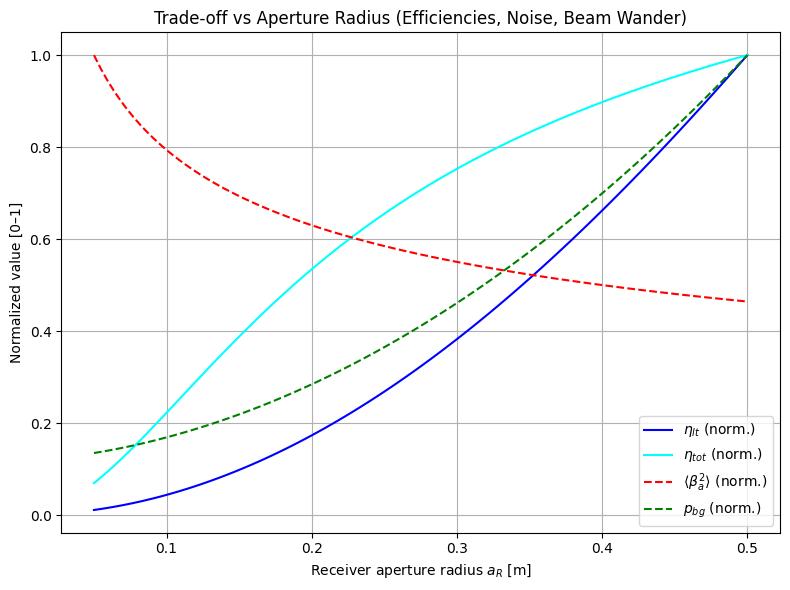

In [5]:
# Plot
def normalize(arr): return np.array(arr)/np.max(arr)

plt.figure(figsize=(8,6))
plt.plot(aR_values, normalize(eta_lt_vals), label=r'$\eta_{lt}$ (norm.)', color='blue')
plt.plot(aR_values, normalize(eta_tot_vals), label=r'$\eta_{tot}$ (norm.)', color='cyan')
plt.plot(aR_values, normalize(beta2_vals), '--', label=r'$\langle \beta_a^2 \rangle$ (norm.)', color='red')
plt.plot(aR_values, normalize(nB_vals), '--', label=r'$p_{bg}$ (norm.)', color='green')

plt.xlabel("Receiver aperture radius $a_R$ [m]")
plt.ylabel("Normalized value [0–1]")
plt.title("Trade-off vs Aperture Radius (Efficiencies, Noise, Beam Wander)")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
